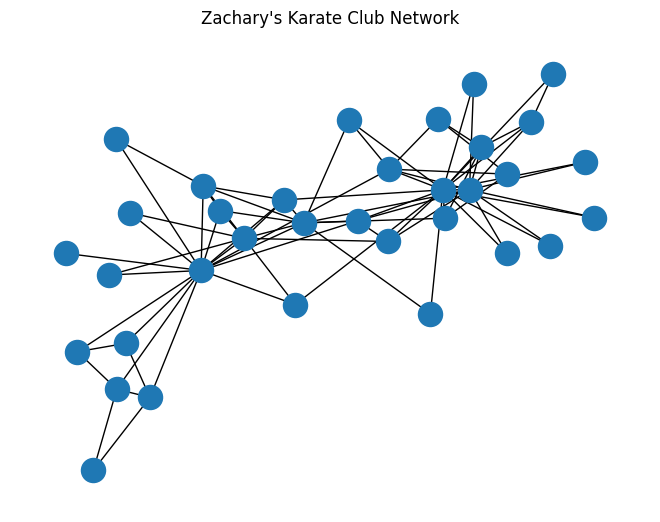

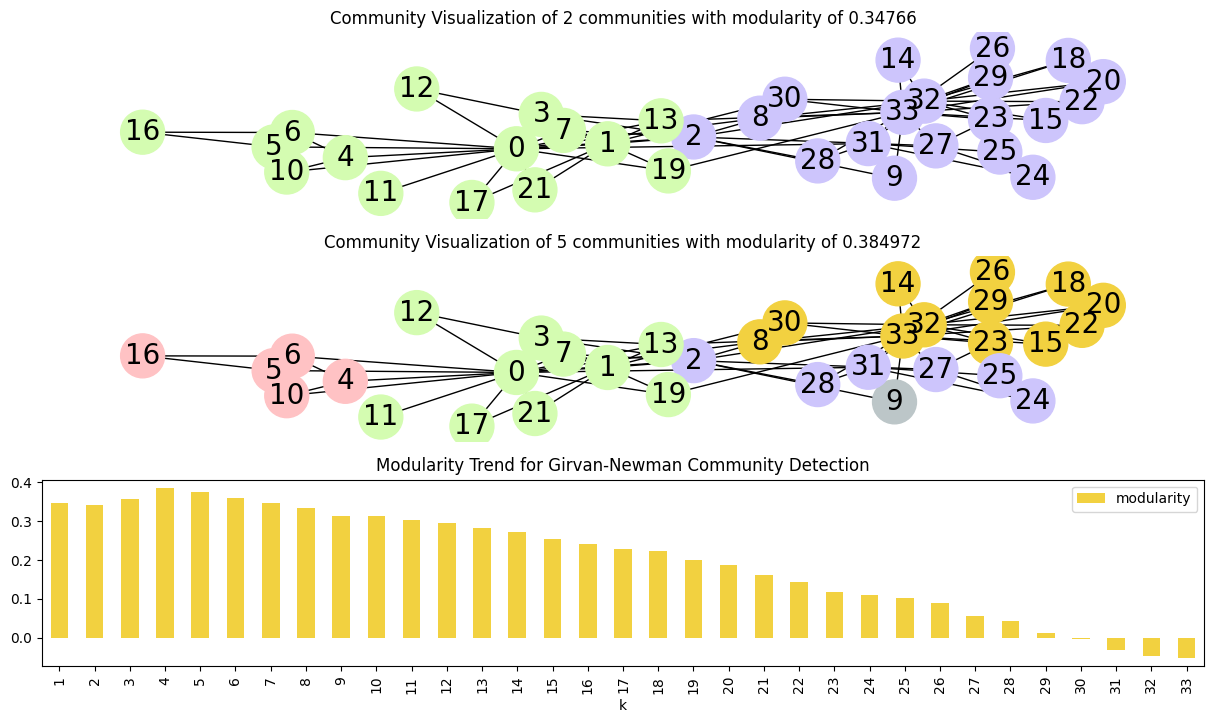

In [2]:
import csv, os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import PySimpleGUI as sg 

working_directory = os.getcwd()

sg.theme('SystemDefault1') 

right_symbol = "🡆"
down_symbol = "🡇"

def collapse(layout, key):
    # sg.pin allows us to display or hide whatever is inside (column)
    return sg.pin(sg.Column(layout, key = key))

def create_table(headers, data):
    
    network_info_layout = [
        [sg.Table(values=data, headings=headers, max_col_width = 35, expand_x = True, expand_y = True, auto_size_columns = True, justification = 'right', alternating_row_color = 'lightGrey', num_rows = 10, display_row_numbers = True, key = '-TABLE-', row_height = 35, tooltip = "Network's Table", enable_click_events = True)],       
        [sg.Button("Close")]
    ]
    
    network_table_window = sg.Window("Graph's Table", network_info_layout, modal = True, element_justification = 'center', resizable = True)
    
    while True:
        event, values = network_table_window.read()
        if event == 'Close' or event == sg.WIN_CLOSED:
            break
            
    network_table_window.close()
   
   
    
def create_plot():
    G = nx.karate_club_graph()
    
    nx.draw(G)
    plt.title('Zachary\'s Karate Club Network')
    plt.grid(True)
    return plt.gcf()

def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)

    for item in figure_canvas_agg.get_tk_widget().find_all():
       figure_canvas_agg.get_tk_widget().delete(item)
 
       
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().pack(side = 'top', fill = 'both', expand = 1)
    
    return figure_canvas_agg

# Community detection algorithm (Girvan-newman)

def Grivan():
        # Load karate graph and find communities using Girvan-Newman
    G = nx.karate_club_graph()
    communities = list(nx.community.girvan_newman(G))

    # Modularity -> measures the strength of division of a network into modules
    modularity_df = pd.DataFrame(
        [
            [k + 1, nx.community.modularity(G, communities[k])]
            for k in range(len(communities))
        ],
        columns=["k", "modularity"],
    )


    # function to create node colour list
    def create_community_node_colors(graph, communities):
        number_of_colors = len(communities[0])
        colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
        node_colors = []
        for node in graph:
            current_community_index = 0
            for community in communities:
                if node in community:
                    node_colors.append(colors[current_community_index])
                    break
                current_community_index += 1
        return node_colors


    # function to plot graph with node colouring based on communities
    def visualize_communities(graph, communities, i):
        node_colors = create_community_node_colors(graph, communities)
        modularity = round(nx.community.modularity(graph, communities), 6)
        title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
        pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
        plt.subplot(3, 1, i)
        plt.title(title)
        nx.draw(
            graph,
            pos=pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size=20,
            font_color="black",
        )


    fig, ax = plt.subplots(3, figsize=(15, 20))

    # Plot graph with colouring based on communities
    visualize_communities(G, communities[0], 1)
    visualize_communities(G, communities[3], 2)

    # Plot change in modularity as the important edges are removed
    modularity_df.plot.bar(
        x="k",
        ax=ax[2],
        color="#F2D140",
        title="Modularity Trend for Girvan-Newman Community Detection",
    )
    return plt.gcf()

def edge_to_remove_from(G):
    dict1 = nx.edge_betweenness_centrality(G)
    list_of_tuples = list(dict1.items())
    list_of_tuples.sort(key = lambda x:x[1], reverse = True)
    return list_of_tuples[0][0]
    
def girvan_newman(G):
    c = list((G.subgraph(s) for s in nx.connected_components(G)))
    l = len(c)
    s = ""
    i= 0
    while(i!=10):
        s += "✘ Edge removed after iteration " + str(i+1) + ": " + str(edge_to_remove_from(G)) + "\n"
        G.remove_edge(*edge_to_remove_from(G))
        i = i + 1
        c = list((G.subgraph(s) for s in nx.connected_components(G)))
        l = len(c)
        s += "◈ Number of Clusters: " + str(l) + "\n" + "\n"
    return s

section_community_detection_algorithms = [
    [sg.Text('Girvan Newman Algorithm', size = (19, 0)), sg.Button('Run', key = '-GNMR-', button_color = 'White')],
]

section_community_detection_evaluations = [
    [sg.Text('Conductance', size = (19, 0)), sg.Button('Run', button_color = 'White')],
    [sg.Text('Modularity', size = (19, 0)), sg.Button('Run', button_color = 'White')],
    [sg.Text('NMI', size = (19, 0)), sg.Button('Run', button_color = 'White')]
]

section_link_analysis_techniques = [
    [sg.Text('Page Rank', size = (19, 0)), sg.Button('Run', button_color = 'White')],
]

col_1 = [
    [sg.Text(down_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_CDA-'), sg.Text("Community Detection Algorithms")],
    [collapse(section_community_detection_algorithms, '-SEC_CDA-')],
    [sg.Text(down_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_CDE-'), sg.Text("Community Detection Evaluations")],
    [collapse(section_community_detection_evaluations, '-SEC_CDE-')],
    [sg.Text(down_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_LA-'), sg.Text("Link Analysis Techniques")],
    [collapse(section_link_analysis_techniques, '-SEC_LA-')]
]

col_2 = [
     [sg.Canvas(size=(500, 500), key = "-CANVAS-")]
]
Grivan_layout = [
     [sg.Canvas(size=(500, 500), key = "-GRIVAN-")]
]
ov=[
    [sg.Column(Grivan_layout)]
]
overview_layout = [
   [sg.Column(col_1), sg.VerticalSeparator(), sg.Column(col_2) ]
]

data_laboratory_layout = [
    [sg.Text('Import Spreadsheet: '), sg.InputText(key = "-FILE_PATH-"), sg.FileBrowse(initial_folder = working_directory, file_types = [("CSV Files", "*.csv")]), sg.Button('Display Details', key = '-DD-'), sg.Button('Display Table' , key = '-DT-')], 
    [sg.Text(key = "-INFO-", background_color = 'White', font = ('Helvetica', 11))],
    [sg.Text(key = "-NOE-", background_color = 'White', font = ('Helvetica', 11))],
    [sg.Text(key = "-NON-", background_color = 'White', font = ('Helvetica', 11))],
    [sg.Text(key = "-ID-", background_color = 'White', font = ('Helvetica', 11))],
    [sg.Text(key = "-D-", background_color = 'White', font = ('Helvetica', 11))],
    [sg.Text(key = "-ACC-", background_color = 'White', font = ('Helvetica', 11))]
]

tab_group = [
    [sg.TabGroup(
                 [[
                     sg.Tab("Overview", overview_layout, background_color = 'White', element_justification = 'left'),
                     sg.Tab("Data Laboratory", data_laboratory_layout, background_color = 'White', element_justification = 'left')
                 ]],
                     tab_location = 'centertop',
                     title_color = 'White', 
                     tab_background_color = 'Grey', 
                     selected_title_color = 'Black',
                     selected_background_color = 'White',
                     border_width = 1
    ),
    
],
    [sg.Button('Exit', button_color = 'White')]
]

window = sg.Window('Mini Social Networks Analysis Tool', tab_group, finalize = True, resizable = True, element_justification = 'center')
draw_figure(window["-CANVAS-"].TKCanvas, create_plot())

opened_cda = True
opened_cde = True
opened_la = True
G = nx.karate_club_graph()
    
while True:
    event,values = window.read()
    if event == "Exit" or event == sg.WIN_CLOSED:
        break
    if event == '-OPEN_SEC_CDA-':
        opened_cda = not opened_cda
        window['-OPEN_SEC_CDA-'].update(down_symbol if opened_cda else right_symbol)
        window['-SEC_CDA-'].update(visible = opened_cda)
    if event == '-OPEN_SEC_CDE-':
        opened_cde = not opened_cde
        window['-OPEN_SEC_CDE-'].update(down_symbol if opened_cde else right_symbol)
        window['-SEC_CDE-'].update(visible = opened_cde)
    if event == '-OPEN_SEC_LA-':
        opened_la = not opened_la
        window['-OPEN_SEC_LA-'].update(down_symbol if opened_la else right_symbol)
        window['-SEC_LA-'].update(visible = opened_la)
    if event == '-DD-':
        window['-NON-'].update(value = "• Number of nodes: " + str(nx.number_of_nodes(G)) + "\n")
        window['-NOE-'].update(value = "• Number of edges: " + str(nx.number_of_edges(G)) + "\n")
        window['-ID-'].update(value = "• Is Directed: " + str(nx.is_directed(G)) + "\n")
        window['-INFO-'].update(value = "\n" + "• Information about graph/network: " + str(nx.info(G)) + "\n")
        window['-D-'].update(value = "• Diameter: " + str(nx.diameter(G)) + "\n")
        window['-ACC-'].update(value = "• Average clustering coefficient: " + str(nx.average_clustering(G)) + "\n")
    
    if event == '-GNMR-':
        window2 = sg.Window('Dynamic Window', ov,finalize = True, resizable = True, element_justification = 'center')
        draw_figure(window2["-GRIVAN-"].TKCanvas, Grivan())

       
        while True:
           event,values = window2.read()
           if event == "Exit" or event == sg.WIN_CLOSED:
              break
           

     
window.close()

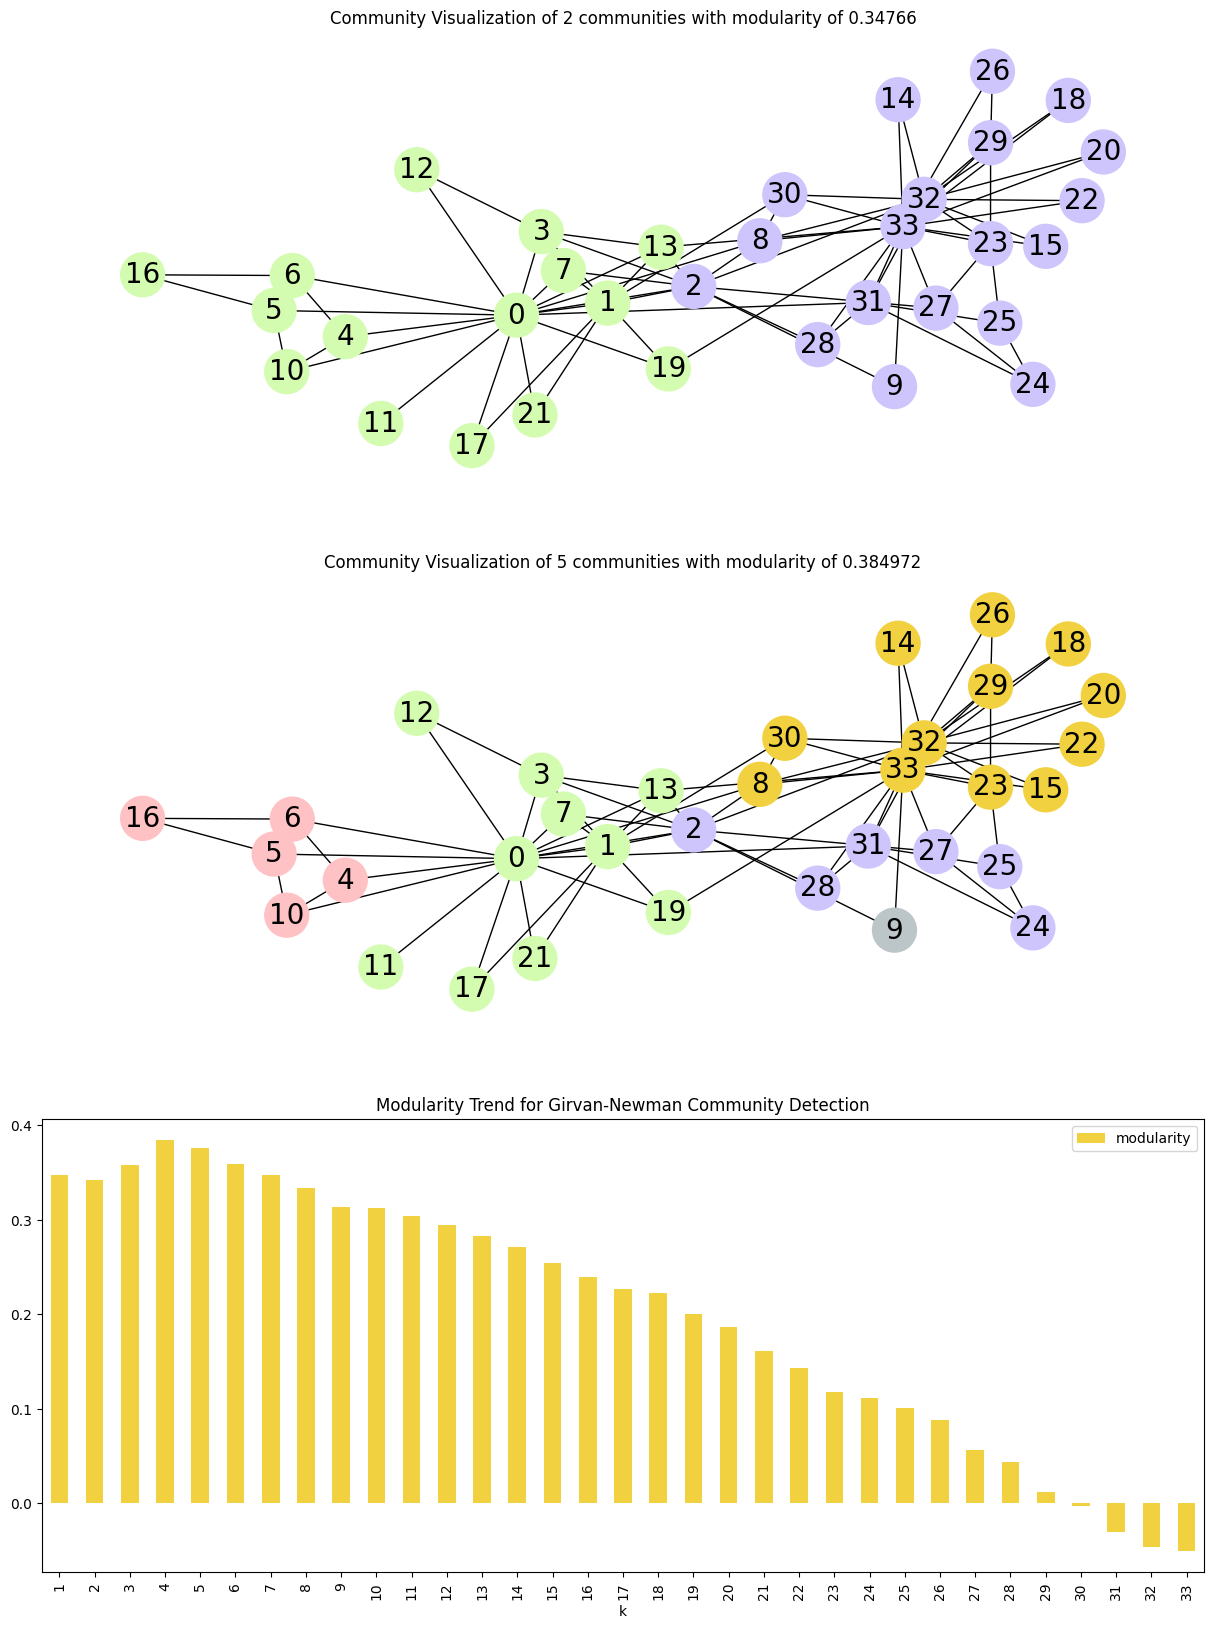

In [ ]:


# Load karate graph and find communities using Girvan-Newman
G = nx.karate_club_graph()
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)


# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


# function to plot graph with node colouring based on communities
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(3, 1, i)
    plt.title(title)
    nx.draw(
        graph,
        pos=pos,
        node_size=1000,
        node_color=node_colors,
        with_labels=True,
        font_size=20,
        font_color="black",
    )


fig, ax = plt.subplots(3, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[0], 1)
visualize_communities(G, communities[3], 2)

# Plot change in modularity as the important edges are removed
modularity_df.plot.bar(
    x="k",
    ax=ax[2],
    color="#F2D140",
    title="Modularity Trend for Girvan-Newman Community Detection",
)
plt.show()